In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in all the raw files
first_pilot = pd.read_csv('first_pilot.csv')
second_pilot = pd.read_csv('second_pilot.csv')
control = pd.read_csv('manipulated_data_control_full_dropped.csv')
publicgood = pd.read_csv('manipulated_data_publicgood_full_dropped.csv')
evaluation = pd.read_csv('manipulated_data_evaluation_full_dropped.csv')

# Introduction & Motivation

We were motivated in figuring out what makes quality of data collected from crowdsourcing platforms better. We know how important the **quality of human labeled data can be for various supervised machine learning algorithm.**
What we were most interested in exploring was to see **if apart from money, are there other treatments that we can provide to increase the quality of the labled datasets collected from the crowd.**  

We used [Figure8](https://www.figure-eight.com/) platform, a highly customizable online tool that can annotate text, images, video, or audio in whatever way is right for your usecase. We chose this platform because: 
1. We have had professional success stories of using this platform for collecting training data
2. We did not want to go with free platform due to lack of availability of responders on these free alternatives
3. Since, this is a paid platform, we wanted to see which treatment beyond payment motivates the responders


# Pilot Studies

## Pilot 1 

![Pilot 1 screenshot](./images/pilot1.png "Pilot1")


In [3]:
# Number of units launched
nul = len(first_pilot._unit_id.unique())
nur = len(first_pilot._worker_id.unique())

\begin{itemize}
\item **Compliance:** In order to check whether responders read the instructions we asked responders to choose **Positive** sentiment whenever they see the sentence **"This is a lion"**. Any person who would choose Negative, will be considered a non complier 
\item **Number of units launched:** {{nul}}
\item **Total unique responders:** {{nur}}
\item **Launch date:** March 26, 2019
\item **Launch time:** 11pm
\item **Completion time:** 7 hours 
\end{itemize}



### Data collected 

**Fields**


    _unit_id: A unique ID number created by the system for each question
    _created_at: The time the contributor submitted the judgement 
    _golden: This will be "true" if this is a test question, otherwise it is "false"
    _id: A unique ID number generated for this specific judgment
    _missed: This will be "true" if the row is an incorrect judgment on a test question.
    _started_at: The time at which the contributor started working on the judgement
    _tainted: This will be "true" if the contributor has been flagged for falling below the required accuracy.
    _channel: The work channel that the contributor accessed the job through.
    _trust: The contributor's accuracy. 
    _worker_id: A unique ID number assigned to the contributor.
    _country: The country the contributor is from.
    _region: A region code for the area the contributor is from.
    _city: The city the contributor is from.
    _ip: The IP address for the contributor.
    _gold: The correct answer for the test question.

In general, we're interested in the variance for each question. We can use **time of response, trust scores, cities and countries** to check the balances between groups. The **tainted indicator** tells us who was dropped and we can report on their statistics. 


In [7]:
first_pilot.sort_values('_started_at').head(5)

,_unit_id,_created_at,_golden,_id,_missed,_started_at,_tainted,_channel,_trust,_worker_id,_country,_region,_city,_ip,please_select_the_sentiment_feeling_of_the_product_review,1,label,please_select_the_sentiment_feeling_of_the_product_review_gold,text,this_is_a_lion
333,2218243929,3/26/2019 02:25:37,True,4661146712,NaN,3/26/2019 02:24:55,False,clixsense,1.0,44980050,TUR,68,Ankara,94.54.16.1,1,NaN,1,1.0,This is a lion,NaN
362,2218245535,3/26/2019 02:25:37,True,4661146708,NaN,3/26/2019 02:24:55,False,clixsense,1.0,44980050,TUR,68,Ankara,94.54.16.1,1,NaN,1,1.0,This is a lion,NaN
300,2216130240,3/26/2019 02:25:37,True,4661146706,NaN,3/26/2019 02:24:55,False,clixsense,1.0,44980050,TUR,68,Ankara,94.54.16.1,1,NaN,1,1.0,This is a lion,NaN
582,2218246446,3/26/2019 02:25:37,True,4661146711,NaN,3/26/2019 02:24:55,False,clixsense,1.0,44980050,TUR,68,Ankara,94.54.16.1,1,NaN,1,1.0,This is a lion,NaN
686,2218246733,3/26/2019 02:25:37,True,4661146715,NaN,3/26/2019 02:24:55,False,clixsense,1.0,44980050,TUR,68,Ankara,94.54.16.1,1,NaN,1,1.0,This is a lion,NaN


### Average response time 

In [11]:
first_pilot['_time_to_respond'] = (first_pilot._created_at.apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))-first_pilot._started_at.apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S")))/5
first_pilot['_time_to_respond'].describe().reset_index().set_index('index').loc[['min', 'max', 'mean']]


,_time_to_respond
index,
min,0 days 00:00:02.400000
max,0 days 00:01:24.800000
mean,0 days 00:00:13.873684


###  Contributor Countries

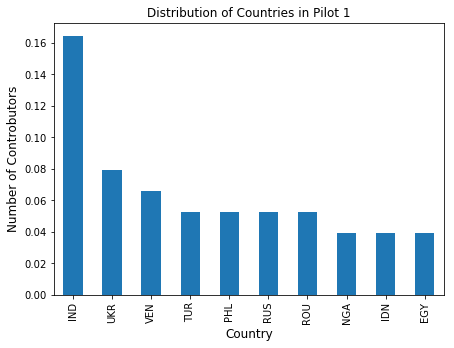

In [12]:
country_count  = first_pilot['_country'].value_counts()
country_count = country_count[:10,]/first_pilot.shape[0]
plt.figure(figsize=(7,5))
country_count.plot(kind='bar')
plt.title('Distribution of Countries in Pilot 1')
plt.ylabel('Number of Controbutors', fontsize=12)
plt.xlabel('Country', fontsize=12)
plt.show()

Since the pilot was launched at 11:00 pm EST, most of the contributors came from the country which are in +5GMT
We saw about 16% of the contributors in pilot 1 coming from India

### Trust distribution of the contributors

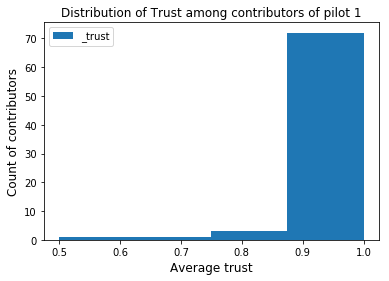

In [28]:
trust_per_worker  = first_pilot[['_trust', '_worker_id']].groupby('_worker_id').mean();
trust_per_worker.plot(kind='hist', bins = 4);
plt.title('Distribution of Trust among contributors of pilot 1')
plt.ylabel('Count of contributors', fontsize=12)
plt.xlabel('Average trust', fontsize=12)
plt.show()

Most of the contributors were high trust contributors. We dont really know how the platform decides the trust value of contributors, however, as long as the distribution of the trust values of the contributors look similar, the experiment results will not be biased due to weaker contributors

### Scores

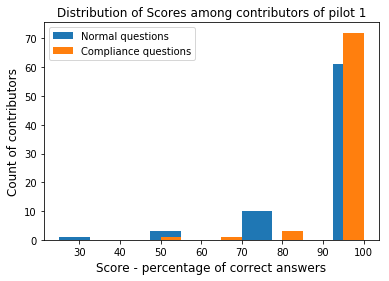

In [44]:
first_pilot['correct_pct'] = 100*first_pilot.label*first_pilot.please_select_the_sentiment_feeling_of_the_product_review \
                        + 100*(1-first_pilot.label)*(1-first_pilot.please_select_the_sentiment_feeling_of_the_product_review)

fp_sbs_norm = first_pilot[first_pilot._golden == False].groupby('_worker_id').mean() #Group by normal questions and get the means.
fp_sbs_comp = first_pilot[first_pilot._golden == True].groupby('_worker_id').mean() #Group by normal questions and get the means.
fp_sbs_norm.correct_pct.hist(label = "Normal questions");
fp_sbs_comp.correct_pct.hist(label = "Compliance questions");
plt.title('Distribution of Scores among contributors of pilot 1')
plt.ylabel('Count of contributors', fontsize=12)
plt.xlabel('Score - percentage of correct answers', fontsize=12)
plt.legend()
plt.grid()
plt.show()

### Lessons learnt

\begin{itemize}
\item **Time of luanch affects the contributor pool** and which part of the world they come from
\item We also noticed that **some workers only got compliance questions**, hence:
    \begin{itemize}
        \item we randomised the units before upoading to the platform for subsequent experiments
        \item included compliance answers when scoring accuracy of a contributor
    \end{itemize}
\item **Almost everyone got compliance right**, that meant they all read the instructions OR they just thought it is indeed a positive experience to see a lion. 
\item **Our questions were too easy**, as seen by the average score of the workers (93%). Indicating that we don't have too much room for improvement using the treatments. 
\end{itemize}

## Pilot 2 

### Number of units launched

In [4]:
# Number of units launched
len(second_pilot._unit_id.unique())

108

### Number of responders

In [5]:
len(second_pilot._worker_id.unique())

34

### Average response time

In [6]:
second_pilot['_time_to_respond'] = (second_pilot._created_at.apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S"))-second_pilot._started_at.apply(lambda x: datetime.strptime(x, "%m/%d/%Y %H:%M:%S")))/5
second_pilot['_time_to_respond'].describe().reset_index().set_index('index')

,_time_to_respond
index,
count,545
mean,0 days 00:00:16.027522
std,0 days 00:00:14.912969
min,0 days 00:00:02.400000
25%,0 days 00:00:06.200000
50%,0 days 00:00:10.400000
75%,0 days 00:00:20.400000
max,0 days 00:01:20


### Contibutor countries

## Design changes for final Experiments

# Experimental Setup

## Control

## Treatment 1 - Public Good

## Treatment 2 - Evaluated

## Defining $\tau$

## Defining Compliance

# Assumptions 

## Exclusion restriction

## Non interference

# Results

# Caveats 

# Conclusion 

# Appendix